In [2]:
import os # operating system
import pandas as pd
import shutil # shell utilities
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
import seaborn as sns
import plotly.express as px

notes for me; there are two ways that we can use pretrained models to make things easier

* feature extraction, which freezes the pretrained layers and adds a new classification layer at the end
    this method is fast and simple, and works well with small-medium datasets

* fine-tuning, which unfreezes some of the top layers so they can update their understanding of the data
    this method takes takes more time and is more advanced, but usually leads to better performance

In [3]:
csvPath = 'harData/Training_set.csv'
df = pd.read_csv(csvPath)

print("Preview of the dataset:")
print(df.head())

Preview of the dataset:
      filename         label
0  Image_1.jpg       sitting
1  Image_2.jpg  using_laptop
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop


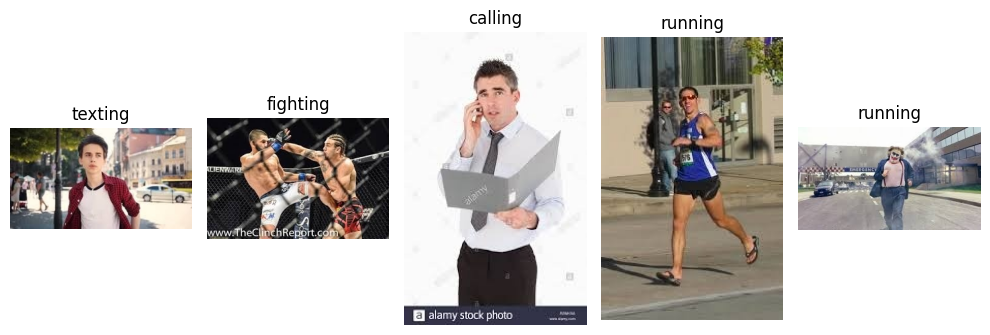

In [32]:
imageFolder = 'harData/train_sorted'
plt.figure(figsize=(10, 6))
randomSample = df.sample(n=5)

for i, (_, row) in enumerate(randomSample.iterrows()): # randomly displays 5 photos in the dataset
    imgPath = os.path.join(imageFolder, row['label'], row['filename'])
    label = row['label']
    image = Image.open(imgPath) # uses pil to open the data

    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()